# 2. 없다면 어떻게 될까? (ResNet Ablation Study)

**핵심적인 기법들을 하나씩 제거했을 때의 효과를 각각 정량적으로 측정하는 ablation study 기법을 배운다. ResNet을 대상으로 실습해 보면서 이론적으로 익힌 기법의 효과를 체감하고 백본을 직접 다뤄보는 실전적 감각을 익힌다.**

## 2-7. 프로젝트: ResNet Ablation Study

---

## 목차
- 0) 라이브러리 버전 확인하기
- 1) ResNet 기본 블록 구성하기
- 2) ResNet-34, ResNet-50 Complete Model
- 3) 일반 네트워크(plain network) 만들기
- 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

---

### 라이브러리 임포트 및 확인

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [14]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import urllib3
urllib3.disable_warnings()

In [19]:
import tensorflow_datasets as tfds

In [15]:
print(tf.__version__)
print(pd.__version__)
print(np.__version__)

2.6.0
1.3.3
1.21.4


### GPU 확인

In [16]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 상수 설정
- BATCH_SIZE 가 클수록 훈련 시간 단축, 1 EPOCH 당 1분 이상 소요됨
- 데이터셋 CIFAR-10 의 경우 40 EPOCHS 정도 수행하는 것을 권장, 15 EPOCHS 정도로도 근접한 성능 얻을 수 있음
- batch_size 와 learning_rate 최고의 조합 찾기 [[참고]](https://inhovation97.tistory.com/32)
    - Best
        - 작은 batch, 낮은 lr (e.g. 16, 0.0001)
        - 큰 batch, 높은 lr (e.g. 256, 0.001)
    - Worst
        - 작은 batch, 높은 lr (e.g. 16, 0.001)
        - 큰 batch, 낮은 lr (e.g. 256, 0.0001)

In [17]:
BATCH_SIZE = 32  # 256
EPOCHS = 10  # 15
LR = 0.1
OPT_DECAY = 0.0001
MOMENTUM = 0.9
L2_WEIGHT_DECAY = 1e-4
BATCH_NORM_DECAY = 0.9
BATCH_NORM_EPSILON = 1e-5

ACTIVATION = 'sigmoid'
NUM_CLASSES = 1

### 데이터 가져와서 확인
- ds_info = tfds.load(): 기본적으로 ~/tensorflow_datasets 경로에 데이터셋 다운로드
- Tensorflow의 데이터셋은 Numpy가 아님 => 다른 방법으로 정보 확인해야 함!
    - ds_info.features  # feature 정보 확인
    - tf.data.experimental.cardinality(ds_train)  # 데이터셋의 이미지 shape와 전체 데이터의 개수, 라벨 클래스의 개수 확인

- 데이터셋 다운로드
    - tfds.load()

In [59]:
import tensorflow_datasets as tfds
ds_info = tfds.load('mnist', with_info=True)

In [61]:

setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [62]:
# tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


- 데이터셋 features 확인
    - ds_info: 데이터셋의 메타 정보

In [63]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


- 데이터셋 개수 확인
    - Tensorflow 데이터셋은 Numpy 가 아님 => ds_train.shape 사용 불가
    - tf.data.experimental.cardinality(ds_train) 로 확인

In [64]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))  # tf.Tensor(18610, shape=(), dtype=int64)
print(tf.data.experimental.cardinality(ds_test))  # tf.Tensor(4652, shape=(), dtype=int64)

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


- 데이터셋 클래스 개수 및 구성 확인

In [65]:
ds_info.features["label"].num_classes  # 2

2

In [66]:
ds_info.features["label"].names  # ['cat', 'dog']

['cat', 'dog']

- 각 이미지 클래스와 인덱스 확인
    - 학습용 데이터셋 확인
    - 평가용 데이터셋 확인

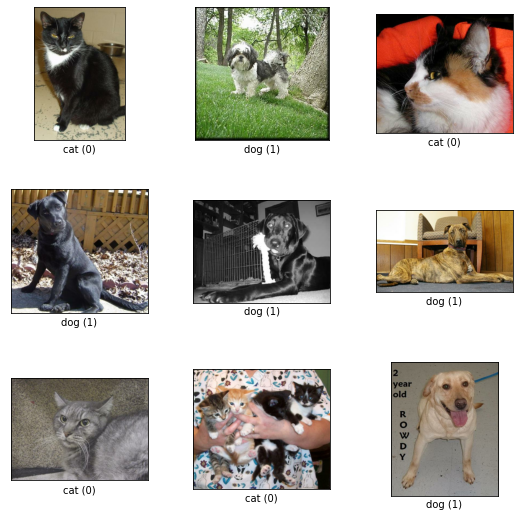

In [67]:
fig = tfds.show_examples(ds_train, ds_info)

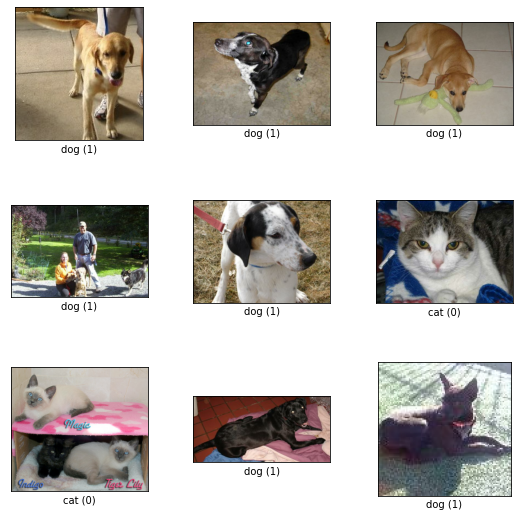

In [68]:
fig = tfds.show_examples(ds_test, ds_info)

### Input Normalization
- Data Normalization: 데이터의 범위를 사용자가 원하는 범위로 제한하는 것
    - 이미지 데이터의 경우 픽셀 정보를 0~255 사이의 값으로 가지는데, 이를 255로 나누어주면 [0, 1] 사이의 값을 가짐
    - f(x) = $\frac{x-x_{min}}{x_{max}-x_{min}}$
    - 사용 이유
        - 머신러닝에서 scale이 큰 feature의 영향이 비대해지는 것을 방지
        - 딥러닝에서 Local optimum에 빠질 위험을 줄임(학습 속도 향상)
    - scikit-learn에서 MinMaxScaler로 쉽게 사용
- 모델에 넣어주기 전에 각 채널별 최댓값인 255로 정규화(normalize)

- 데이터 전처리
    - 학습 데이터와 검증 데이터에 normalizing 과 resizing 적용

In [69]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

- 전처리 포함한 배치 구성

In [70]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

- 데이터셋에 전처리와 배치 처리 적용

In [71]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

- 구성된 배치 모양 확인

In [72]:
for input in ds_train.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(32, 224, 224, 3)
(32,)


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


### ResNet, Plain 구현

- 블록을 단위로 모델을 만들 수 있어야 함!
    - 블록(block): 일반적인 딥러닝 모델에서 이렇게 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위
    - 레이어(layer): 기본적으로 텐서플로우(TensorFlow), 케라스(Keras), 파이토치(PyTorch) 등에서 기본적으로 제공하는 단위
- ResNet
    - ResNet-18, 34, 50, 101, 152<br>![](https://d3s0tskafalll9.cloudfront.net/media/images/resnet.max-800x600.png)
- Plain: ResNet 에서 Residual Block 이 없는 형태
    - ResNet-34, Plain-34<br>![](https://d3s0tskafalll9.cloudfront.net/media/images/F-22-14.max-800x600.png)

#### 블록 생성 함수

In [73]:
def conv_block(input_layer, 
                channel, 
                kernel_size, 
                strides=1, 
                activation='relu',
                l2_weight_decay=1e-4,
                batch_norm_decay=0.9,
                batch_norm_epsilon=1e-5):
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=kernel_size,
        kernel_initializer='he_normal',
        kernel_regularizer=keras.regularizers.l2(l2_weight_decay),
        padding='same',
        strides=strides,
        use_bias=False,
    )(input_layer)
    
    x = keras.layers.BatchNormalization(
        # momentum=batch_norm_decay,
        # epsilon=batch_norm_epsilon,
    )(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [74]:
def build_net_block(input_layer, 
                    cnn_count=3, 
                    channel=64, 
                    block_num=0, 
                    is_50=True,
                    is_ResNet=True):

    x = input_layer
    
    # 첫 번째 conv_layer 에서 strides=2 설정해서 너비와 높이를 줄임
    # => 필터의 개수(=채널)가 증가할 때마다 너비와 높이를 줄임

    # ResNet-50, Plain-50
    if is_50:
        if is_ResNet: # ResNet-50
            for i in range(cnn_count):
                if i == 0:
                    shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-50
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
                else:
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
    # ResNet-34, Plain-34
    else:
        if is_ResNet:  # ResNet-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3))
                else:
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3))

    return x

#### 모델 생성 함수

In [75]:
def build_net(input_shape=(32,32,3),
                cnn_count_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=10, 
                is_50=True,
                is_ResNet=True,
                activation='softmax',
                name='ResNet_50'):
    
    # 모델 생성 전, config list들이 같은 길이인지 확인
    assert len(cnn_count_list) == len(channel_list)
    
    # input layer 생성
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer 설정
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서
    # - is_ResNet=True 일 경우, Residual block 블록을 생성합니다.
    # - is_ResNet=False 일 경우, Plain block 블록을 생성합니다.
    for block_num, (cnn_count, channel) in enumerate(zip(cnn_count_list, channel_list)):
        x = build_net_block(x, 
                            cnn_count=cnn_count, 
                            channel=channel, 
                            block_num=block_num, 
                            is_50=is_50,
                            is_ResNet=is_ResNet)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                        activation=activation, 
                        kernel_initializer='he_normal'
                        )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

#### 모델 생성 및 확인

- ResNet-34, ResNet-50 생성

In [76]:
resnet_34 = build_net(
    input_shape=(224,224,3),
    is_50=False,
    is_ResNet=True,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='ResNet_34',
)
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
__________________________________________________________________________________________

In [77]:
resnet_50 = build_net(
    input_shape=(224,224,3),
    is_50=True,
    is_ResNet=True,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='ResNet_50',
)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 112, 112, 64) 9408        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 112, 112, 64) 256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 112, 112, 64) 0           batch_normalization_36[0][0]     
__________________________________________________________________________________________

- Plain-34, Plain-50 생성

In [78]:
plain_34 = build_net(
    input_shape=(224,224,3),
    is_50=False,
    is_ResNet=False,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='Plain_34',
)
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 56, 56, 64)        36864     
_________________________________________________________________
batch_normalization_90 (Batc (None, 56, 56, 64)        256

In [79]:
plain_50 = build_net(
    input_shape=(224,224,3),
    is_50=True,
    is_ResNet=False,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='Plain_50',
)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_122 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 64)        4096      
_________________________________________________________________
batch_normalization_123 (Bat (None, 56, 56, 64)        256

### ResNet vs Plain 비교

#### 학습

- 모델 학습 함수
    - 데이터셋이 작을 경우, Adam 보다 SGD 가 더 학습에 유리하다.

In [80]:
def comile_and_fit(model, ds_train, ds_test, ds_info, learning_rate=0.001, momentum= 0.9, opt_decay=0.0001, batch_size=128, epochs=15):
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.SGD(
            learning_rate=learning_rate,
            momentum=momentum,
            decay=opt_decay,
            clipnorm=1.
        ),
        metrics=['accuracy'],
    )

    history = model.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['train[80%:]'].num_examples/batch_size),
        epochs=epochs,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history

- ResNet-34 학습

In [82]:
history_resnet_34 = comile_and_fit(resnet_34, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10


  3/581 [..............................] - ETA: 1:38 - loss: 0.5556 - accuracy: 0.9375 

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 49/581 [=>............................] - ETA: 1:31 - loss: 0.5364 - accuracy: 0.9337

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:19 - loss: 0.5863 - accuracy: 0.9031

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


315/581 [===============>..............] - ETA: 45s - loss: 0.6001 - accuracy: 0.8967

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 42s - loss: 0.6000 - accuracy: 0.8959

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 41s - loss: 0.5997 - accuracy: 0.8960

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


365/581 [=================>............] - ETA: 37s - loss: 0.5991 - accuracy: 0.8959

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 36s - loss: 0.6004 - accuracy: 0.8958

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


577/581 [============================>.] - ETA: 0s - loss: 0.5826 - accuracy: 0.9000

581/581 [==============================] - ETA: 0s - loss: 0.5827 - accuracy: 0.9000

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 130s 202ms/step - loss: 0.5827 - accuracy: 0.9000 - val_loss: 0.7782 - val_accuracy: 0.7820
Epoch 2/10
  1/581 [..............................] - ETA: 1:40 - loss: 0.5020 - accuracy: 0.9062

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 42/581 [=>............................] - ETA: 1:35 - loss: 0.5435 - accuracy: 0.9008

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 1:24 - loss: 0.5479 - accuracy: 0.9042

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 47s - loss: 0.5319 - accuracy: 0.9088

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 45s - loss: 0.5296 - accuracy: 0.9096

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 43s - loss: 0.5285 - accuracy: 0.9101

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 38s - loss: 0.5257 - accuracy: 0.9107

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 37s - loss: 0.5243 - accuracy: 0.9115

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


569/581 [============================>.] - ETA: 2s - loss: 0.5141 - accuracy: 0.9136

581/581 [==============================] - ETA: 0s - loss: 0.5129 - accuracy: 0.9139

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 123s 211ms/step - loss: 0.5129 - accuracy: 0.9139 - val_loss: 0.6455 - val_accuracy: 0.8677
Epoch 3/10
  3/581 [..............................] - ETA: 1:43 - loss: 0.4160 - accuracy: 0.9479

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 1:41 - loss: 0.4293 - accuracy: 0.9392

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 1:26 - loss: 0.4603 - accuracy: 0.9260

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 47s - loss: 0.4629 - accuracy: 0.9232

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 46s - loss: 0.4622 - accuracy: 0.9235

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 43s - loss: 0.4619 - accuracy: 0.9238

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 38s - loss: 0.4611 - accuracy: 0.9237

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 37s - loss: 0.4604 - accuracy: 0.9238

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


571/581 [============================>.] - ETA: 1s - loss: 0.4550 - accuracy: 0.9249

581/581 [==============================] - ETA: 0s - loss: 0.4556 - accuracy: 0.9250

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 125s 215ms/step - loss: 0.4556 - accuracy: 0.9250 - val_loss: 1.4903 - val_accuracy: 0.5478
Epoch 4/10
  2/581 [..............................] - ETA: 1:43 - loss: 0.5219 - accuracy: 0.8750

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 40/581 [=>............................] - ETA: 1:38 - loss: 0.4217 - accuracy: 0.9336

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 1:24 - loss: 0.4321 - accuracy: 0.9298

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 46s - loss: 0.4194 - accuracy: 0.9352

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 45s - loss: 0.4191 - accuracy: 0.9351

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 42s - loss: 0.4203 - accuracy: 0.9338

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 37s - loss: 0.4175 - accuracy: 0.9345

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 36s - loss: 0.4184 - accuracy: 0.9339

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


578/581 [============================>.] - ETA: 0s - loss: 0.4082 - accuracy: 0.9379

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.4080 - accuracy: 0.9379

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 125s 214ms/step - loss: 0.4080 - accuracy: 0.9379 - val_loss: 0.5276 - val_accuracy: 0.8877
Epoch 5/10
  3/581 [..............................] - ETA: 1:40 - loss: 0.3491 - accuracy: 0.9583

 36/581 [>.............................] - ETA: 1:35 - loss: 0.3696 - accuracy: 0.9523

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


108/581 [====>.........................] - ETA: 1:22 - loss: 0.3773 - accuracy: 0.9439

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 45s - loss: 0.3777 - accuracy: 0.9428

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 44s - loss: 0.3788 - accuracy: 0.9423

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 42s - loss: 0.3793 - accuracy: 0.9422

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


365/581 [=================>............] - ETA: 37s - loss: 0.3784 - accuracy: 0.9429

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 36s - loss: 0.3774 - accuracy: 0.9433

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


572/581 [============================>.] - ETA: 1s - loss: 0.3701 - accuracy: 0.9454

581/581 [==============================] - ETA: 0s - loss: 0.3695 - accuracy: 0.9457

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 120s 207ms/step - loss: 0.3695 - accuracy: 0.9457 - val_loss: 0.4654 - val_accuracy: 0.8972
Epoch 6/10
  3/581 [..............................] - ETA: 1:38 - loss: 0.4060 - accuracy: 0.9271

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:34 - loss: 0.3496 - accuracy: 0.9557

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


108/581 [====>.........................] - ETA: 1:22 - loss: 0.3734 - accuracy: 0.9413

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 45s - loss: 0.3566 - accuracy: 0.9475

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 44s - loss: 0.3563 - accuracy: 0.9477

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 41s - loss: 0.3537 - accuracy: 0.9488

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 36s - loss: 0.3520 - accuracy: 0.9495

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 35s - loss: 0.3527 - accuracy: 0.9493

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.9476

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.3544 - accuracy: 0.9475

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 120s 206ms/step - loss: 0.3544 - accuracy: 0.9475 - val_loss: 1.2364 - val_accuracy: 0.6582
Epoch 7/10
 34/581 [>.............................] - ETA: 1:34 - loss: 0.3467 - accuracy: 0.9403

 43/581 [=>............................] - ETA: 1:33 - loss: 0.3443 - accuracy: 0.9448

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 1:21 - loss: 0.3248 - accuracy: 0.9583

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


307/581 [==============>...............] - ETA: 47s - loss: 0.3291 - accuracy: 0.9543

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 42s - loss: 0.3270 - accuracy: 0.9548

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 40s - loss: 0.3269 - accuracy: 0.9550

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 36s - loss: 0.3241 - accuracy: 0.9561

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 35s - loss: 0.3237 - accuracy: 0.9563

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.3164 - accuracy: 0.9592

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 0.3164 - accuracy: 0.9592 - val_loss: 0.4232 - val_accuracy: 0.9082
Epoch 8/10
  1/581 [..............................] - ETA: 1:38 - loss: 0.2724 - accuracy: 0.9688

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 1:34 - loss: 0.2901 - accuracy: 0.9688

 35/581 [>.............................] - ETA: 1:34 - loss: 0.2895 - accuracy: 0.9688

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/581 [====>.........................] - ETA: 1:22 - loss: 0.2971 - accuracy: 0.9659

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


316/581 [===============>..............] - ETA: 46s - loss: 0.2990 - accuracy: 0.9633

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 44s - loss: 0.2983 - accuracy: 0.9635

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 42s - loss: 0.2971 - accuracy: 0.9640

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


368/581 [==================>...........] - ETA: 37s - loss: 0.2983 - accuracy: 0.9637

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 36s - loss: 0.2989 - accuracy: 0.9633

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.2943 - accuracy: 0.9648

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 0.2943 - accuracy: 0.9648 - val_loss: 1.0297 - val_accuracy: 0.6786
Epoch 9/10
 34/581 [>.............................] - ETA: 1:34 - loss: 0.2917 - accuracy: 0.9660

 40/581 [=>............................] - ETA: 1:33 - loss: 0.2905 - accuracy: 0.9656

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:21 - loss: 0.2834 - accuracy: 0.9649

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


312/581 [===============>..............] - ETA: 46s - loss: 0.2856 - accuracy: 0.9639

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 43s - loss: 0.2849 - accuracy: 0.9642

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 42s - loss: 0.2843 - accuracy: 0.9646

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


366/581 [=================>............] - ETA: 37s - loss: 0.2836 - accuracy: 0.9648

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 36s - loss: 0.2842 - accuracy: 0.9646

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.2843 - accuracy: 0.9645

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 119s 204ms/step - loss: 0.2843 - accuracy: 0.9645 - val_loss: 0.5973 - val_accuracy: 0.8573
Epoch 10/10
  4/581 [..............................] - ETA: 1:39 - loss: 0.2621 - accuracy: 0.9766

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:34 - loss: 0.2615 - accuracy: 0.9731

 43/581 [=>............................] - ETA: 1:33 - loss: 0.2603 - accuracy: 0.9738

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 1:19 - loss: 0.2769 - accuracy: 0.9699

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


317/581 [===============>..............] - ETA: 46s - loss: 0.2695 - accuracy: 0.9693

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 42s - loss: 0.2695 - accuracy: 0.9694

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 42s - loss: 0.2698 - accuracy: 0.9693

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


368/581 [==================>...........] - ETA: 37s - loss: 0.2683 - accuracy: 0.9699

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 36s - loss: 0.2682 - accuracy: 0.9701

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.9688

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 117s 202ms/step - loss: 0.2708 - accuracy: 0.9688 - val_loss: 0.5020 - val_accuracy: 0.8976


- Plain-34 학습

In [ ]:
history_plain_34 = comile_and_fit(plain_34, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10
  6/581 [..............................] - ETA: 1:33 - loss: 2.5253 - accuracy: 0.4948

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 21/581 [>.............................] - ETA: 1:31 - loss: 2.4268 - accuracy: 0.4940

 36/581 [>.............................] - ETA: 1:30 - loss: 2.4553 - accuracy: 0.4852

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 89/581 [===>..........................] - ETA: 1:21 - loss: 2.3848 - accuracy: 0.5039

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


313/581 [===============>..............] - ETA: 44s - loss: 2.2221 - accuracy: 0.5066

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 41s - loss: 2.2172 - accuracy: 0.5060

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 37s - loss: 2.2058 - accuracy: 0.5071

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 33s - loss: 2.1973 - accuracy: 0.5097

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.1275 - accuracy: 0.5169

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 124s 192ms/step - loss: 2.1275 - accuracy: 0.5169 - val_loss: 1.9514 - val_accuracy: 0.5353
Epoch 2/10
 27/581 [>.............................] - ETA: 1:30 - loss: 1.9450 - accuracy: 0.5197

 39/581 [=>............................] - ETA: 1:28 - loss: 1.9425 - accuracy: 0.5240

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 1:17 - loss: 1.9205 - accuracy: 0.5516

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 43s - loss: 1.8756 - accuracy: 0.5398

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 41s - loss: 1.8730 - accuracy: 0.5402

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 39s - loss: 1.8708 - accuracy: 0.5412

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 34s - loss: 1.8646 - accuracy: 0.5427

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 33s - loss: 1.8634 - accuracy: 0.5433

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


576/581 [============================>.] - ETA: 0s - loss: 1.8213 - accuracy: 0.5464

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.8204 - accuracy: 0.5460

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 194ms/step - loss: 1.8204 - accuracy: 0.5460 - val_loss: 1.7088 - val_accuracy: 0.4848
Epoch 3/10
 25/581 [>.............................] - ETA: 1:31 - loss: 1.6967 - accuracy: 0.5300

 38/581 [>.............................] - ETA: 1:29 - loss: 1.6951 - accuracy: 0.5461

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 1:17 - loss: 1.6814 - accuracy: 0.5552

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


318/581 [===============>..............] - ETA: 43s - loss: 1.6451 - accuracy: 0.5529

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 41s - loss: 1.6430 - accuracy: 0.5548

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 39s - loss: 1.6413 - accuracy: 0.5548

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


369/581 [==================>...........] - ETA: 35s - loss: 1.6363 - accuracy: 0.5565

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 34s - loss: 1.6357 - accuracy: 0.5562

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


545/581 [===========================>..] - ETA: 5s - loss: 1.6088 - accuracy: 0.5578

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.6028 - accuracy: 0.5602

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 115s 198ms/step - loss: 1.6028 - accuracy: 0.5602 - val_loss: 1.5018 - val_accuracy: 0.5931
Epoch 4/10
 34/581 [>.............................] - ETA: 1:29 - loss: 1.5108 - accuracy: 0.5671

 43/581 [=>............................] - ETA: 1:28 - loss: 1.5056 - accuracy: 0.5792

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:15 - loss: 1.4950 - accuracy: 0.5767

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 42s - loss: 1.4589 - accuracy: 0.6006

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 40s - loss: 1.4579 - accuracy: 0.5995

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 38s - loss: 1.4555 - accuracy: 0.6005

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 34s - loss: 1.4520 - accuracy: 0.6001

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 33s - loss: 1.4510 - accuracy: 0.6005

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.4210 - accuracy: 0.6091

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


- ResNet-50 학습

In [ ]:
history_resnet_50 = comile_and_fit(resnet_50, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

- Plain-50 학습

In [ ]:
history_plain_50 = comile_and_fit(plain_50, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

#### 학습 결과 시각화 및 저장

- ResNet-34, Plain-34
    - Training Loss
    - Training Accuracy

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Training Loss (ResNet-34 & Plain-34)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

# ResNet-34, Plain-34 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_plain_34.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-34 & Plain-34)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Training_Loss_and_Accuracy_of_34.png')

plt.show()

- ResNet-50, Plain-50
    - Training Loss
    - Training Accuracy

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-50, Plain-50 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Training Loss (ResNet-50 & Plain-50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

# ResNet-50, Plain-50 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_50.history['accuracy'], 'r')
plt.plot(history_plain_50.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-50 & Plain-50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Training_Loss_and_Accuracy_of_50.png')

plt.show()

- ResNet-34, Plain-34, ResNet-50, Plain-50
    - Training Loss
    - Training Accuracy

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'y')
plt.plot(history_plain_50.history['loss'], 'g')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_34'], loc='upper left')

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_resnet_50.history['accuracy'], 'b')
plt.plot(history_plain_34.history['accuracy'], 'y')
plt.plot(history_plain_50.history['accuracy'], 'g')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Training_Loss_and_Accuracy_of_All.png')

plt.show()

- ResNet-34, Plain-34
    - Validation Loss
    - Validation Accuracy

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_plain_34.history['val_loss'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

# ResNet-34, Plain-34 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Validation_Loss_and_Accuracy_of_34.png')

plt.show()

- ResNet-50, Plain-50
    - Validation Loss
    - Validation Accuracy

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-50, Plain-50 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_50.history['val_loss'], 'r')
plt.plot(history_plain_50.history['val_loss'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

# ResNet-50, Plain-50 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Validation_Loss_and_Accuracy_of_50.png')

plt.show()

- ResNet-34, Plain-34, ResNet-50, Plain-50
    - Validation Loss
    - Validation Accuracy

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34, ResNet-50, Plain-50 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_resnet_50.history['val_loss'], 'b')
plt.plot(history_plain_34.history['val_loss'], 'y')
plt.plot(history_plain_50.history['val_loss'], 'g')
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

# ResNet-34, Plain-34, ResNet-50, Plain-50 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'y')
plt.plot(history_plain_50.history['val_accuracy'], 'g')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Validation_Loss_and_Accuracy_of_All.png')

plt.show()

### 학습 결과 데이터 프레임으로 확인

- ResNet, Plain 학습 결과 데이터 프레임으로 저장

In [ ]:
# ResNet, Plain 학습 결과 평균값을 딕셔너리로 저장
model_result = {
    'ResNet-34': [
        round(np.array(history_resnet_34.history['loss']).mean(), 2),
        round(np.array(history_resnet_34.history['accuracy']).mean(), 2),
        round(np.array(history_resnet_34.history['val_loss']).mean(), 2),
        round(np.array(history_resnet_34.history['val_accuracy']).mean(), 2)
    ],
    'Plain-34': [
        round(np.array(history_plain_34.history['loss']).mean(), 2),
        round(np.array(history_plain_34.history['accuracy']).mean(), 2),
        round(np.array(history_plain_34.history['val_loss']).mean(), 2),
        round(np.array(history_plain_34.history['val_accuracy']).mean(), 2)
    ],
    'ResNet-50': [
        round(np.array(history_resnet_50.history['loss']).mean(), 2),
        round(np.array(history_resnet_50.history['accuracy']).mean(), 2),
        round(np.array(history_resnet_50.history['val_loss']).mean(), 2),
        round(np.array(history_resnet_50.history['val_accuracy']).mean(), 2)
    ],
    'Plain-50': [
        round(np.array(history_plain_50.history['loss']).mean(), 2),
        round(np.array(history_plain_50.history['accuracy']).mean(), 2),
        round(np.array(history_plain_50.history['val_loss']).mean(), 2),
        round(np.array(history_plain_50.history['val_accuracy']).mean(), 2)
    ],    
}

# 데이터 프레임 생성
df_model_result = pd.DataFrame(model_result, index=['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'])
df_model_result

- Validation Accuracy 기준으로 Ablation Study 결과표 작성

In [ ]:
df_val_acc = pd.DataFrame(df_model_result.loc['Validation Accuracy'], columns=['Validation Accuracy'])
df_val_acc

---

### 결과 정리

- 시각화 비교

||Training<br>Loss and Accuracy|Validation<br>Loss and Accuracy|
|:---:|:---:|:---:|
|34|![](result/Training_Loss_and_Accuracy_of_34.png)|![](result/Validation_Loss_and_Accuracy_of_34.png)|
|50|![](result/Training_Loss_and_Accuracy_of_50.png)|![](result/Validation_Loss_and_Accuracy_of_50.png)|
|All|![](result/Training_Loss_and_Accuracy_of_All.png)|![](result/Validation_Loss_and_Accuracy_of_All.png)|

- 결과 비교

In [ ]:
# ResNet-34, Plain-34, ResNet-50, Plain-50 학습 결과
df_model_result

In [ ]:
# Validation Accuracy 기준으로 결과 확인
df_val_acc

- 결론

epochs=10 으로 학습을 진행했다. Training Loss, Validation Loss 는 epoch 이 진행될수록 ResNet 이 PlainNet 보다 값이 작아졌고 Training Accuracy, Validation Accuracy 는 시작부터 압도적으로 ResNet 이 PlainNet 보다 값이 컸다. PlainNet 에 비해 ResNet 의 성능이 개선되었음을 알 수 있다. _좀 더 결과를 보고 싶다면 epochs=40 이상으로 진행해보면 좋을 것이다._

=> **성능: ResNet > PlainNet**

---

배운 점 :  ResNet, Plain 에 대해 잘 알수 있었다
아쉬운 점 : 다른사람의 코드 작성한 것을 참고하여 진행했는데, 이해가 되지 않는 부분이 많았다. 
느낀 점 : 혼자 작성할 수 있는 코드능력이 잇으면 좋겠다
어려웠던 점 : 기존 코드 작성했던 노드1번과 차이점이 커서 보는데에 조금 어려움이 있었다.

In [ ]:
# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
VGG 구현하는 방식을 알려줬으나 그걸 토대로 ResNet 논문을 코드로 구현하는 건 여전히 어렵다. 구글링과 펀더멘탈 22 코드를 참고할 수 밖에 없었다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- Ablation Study [[참고1]](https://cumulu-s.tistory.com/8) [[참고2]](https://fintecuriosity-11.tistory.com/73)
    - 의학/심리학 연구: 장기, 조직, 혹은 살아있는 유기체의 어떤 부분을 수술적인 제거 후에 이것이 없을때 해당 유기체의 행동을 관찰하는 것을 통해서 장기, 조직, 혹은 살아있는 유기체의 어떤 부분의 역할이나 기능을 실험해보는 방법
    - 머신러닝
        - machine learning system의 building blocks을 제거해서 전체 성능에 미치는 효과에 대한 insight를 얻기 위한 과학적 실험
        - "An ablation study typically refers to removing some "feature" of the model of algorithm, and seeing how that affects performance".
    - ![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FlWXxn%2FbtqGCect7wb%2FII68a8fSRJ6g1BNtqatxHk%2Fimg.png)
- ResNet & Plain 구조<br>![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fdek2kD%2FbtqTfCx4XTn%2FkMHkA7Fv8vbW5Hkmg1x3a0%2Fimg.png)
- ResNet
    - 잔차(Residual)<br>![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fbmdg7R%2FbtqYDjgD1TR%2Fp6qeoRgyJlJvBjKnTPNB9k%2Fimg.png)
        - 최적의 H(x)를 찾는 것이 아니라 H(x) - x를 찾는 것
        - 이전 layer의 결과를 다시 이용하는 것
        - 입력에서 출력으로 바로 연결되는 shortcut만 추가 => 파라미터 수에 영향이 없으며, 덧셈이 늘어나는 것을 제외하면 shortcut 연결을 통한 연산량 증가는 없다. => forward와 backward path가 단순해지는 효과가 있었으며, gradient의 소멸 문제를 해결할 수 있다.
        - 심층신경망의 degradation 문제 해결
    - 구조
        - VGG-19 구조를 뼈대로 함
        - 3x3 Convolution, Max pooling 한 번 사용, Hidden FC, Dropout을 사용하지 않음
        - 50/101/152 Layer는 Bottleneck이라는 구조로 변경
            - bottleneck design은 신경망의 복잡도를 감소하기 위해 사용<br>![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FB5i5c%2FbtqYDjnmO9t%2F4mYzLdkp1eIeUUs68vkepK%2Fimg.png)
        - Plain 모델에 기반하여 Shortcut connection을 추가하여 구성
            - shortcut이 feature map을 2 size씩 건너뛰므로 stride를 2로 설정
        - input과 output의 차원
            - 같다면, identity shortcut을 바로 사용
            - dimension이 증가했을 경우
                - zero padding을 적용하여 차원을 키움
                - projection shortcut을 사용 (1x1 conv)
    - 참고
        - 코드 구현 참고: [[1]](https://git.dst.etit.tu-chemnitz.de/external/tf-models/-/blob/1d057dfc32f515a63ab1e23fd72052ab2a954952/official/vision/image_classification/resnet_model.py) [[2]](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py#L20) [[3]](https://github.com/calmisential/TensorFlow2.0_ResNet/blob/master/models/resnet.py)
        - ResNet 구조 참고: [[1]](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) [[2]](https://oi.readthedocs.io/en/latest/computer_vision/cnn/resnet.html)
        - 논문 리뷰 참고: [[1]](https://phil-baek.tistory.com/entry/ResNet-Deep-Residual-Learning-for-Image-Recognition-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0) [[3]](https://deep-learning-study.tistory.com/473) [[2]](https://youtu.be/671BsKl8d0E)
- Plain
    - skip/shortcut connection을 사용하지 않은 일반적인 CNN(AlexNet, VGGNet) 신경망
    - plaing network가 점점 깊어질 수록 기울기(gradient) 소실(vanishing)과 폭발(exploding) 문제가 발생
    - 구조
        - conv filter의 사이즈 3 x 3
        - stride가 2인 conv filter를 사용
        - GAP를 사용
        - 사이즈가 1,000인 FC layer와 Softmax를 사용


### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?|블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
>|2|구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.|
>|3|Ablation Study 결과가 바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|

블록 함수를 만든 다음 모델(ResNet-34, ResNet-50, Plain-34, Plain-50)을 구현하고 summary 를 출력했다. 구글링과 펀더멘탈 22 를 참고했다.

모든 모델의 학습은 epochs=10 으로 진행한 후 ResNet 과 PlainNet 의 결과를 시각화해서 확인했다. Training Loss 는 특정 epoch 값을 넘으면 ResNet 이 PlainNet 보다 낮아졌고 Training Accuracy 는 시작부터 ResNet 이 압도적으로 높았다. Validation Loss 또한 마찬가지로 특정 epoch 값을 넘으면 ResNet 이 PlainNet 보다 낮아졌고 Validation Accuracy 는 ResNet 이 갈수록 높아지는 것을 볼 수 있다. ResNet 이 PlainNet 보다 성능이 뛰어났다.

학습 결과를 데이터 프레임으로 만들어서 출력해서 결과표를 만들었다. 루브릭 기준에 맞추기 위해 validation accuracy 만 뽑아내서 다시 데이터 프레임으로 만들고 ablation study 결과표 작성을 끝냈다. 시각화로 봤을 때보다 숫자로 딱 적혀 있으니 좀 더 정확히 성능 개선 정도를 알 수 있었다.


### - 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
없음

### - **자기 다짐**
- 다음에는 epoch=40 으로 실행 결과를 봐야겠다.
- 계속 다시 보면서 논문 내용을 코드로 구현하는 방법을 체득해야 겠다.